## Preparing

In [1]:
!git init .
!git remote add -f origin "https://github.com/Sankek/ImageInpainting"
# !git pull origin master
!git pull origin adversarial
!git checkout adversarial


Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 178 (delta 94), reused 122 (delta 47), pack-reused 0
Receiving objects: 100% (178/178), 5.81 MiB | 15.70 MiB/s, done.
Resolving deltas: 100% (94/94), done.
From https://github.com/Sankek/ImageInpainting
 * [new branch]      adversarial -> origin/adversarial
 * [new branch]      master      -> origin/master
From https://github.com/Sankek/ImageInpainting
 * branch            adversarial -> FETCH_HEAD
Branch 'adversarial' set up to track remote branch 'adversarial' from 'origin'.
Switched to a new branch 'adversarial'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# unzipping archive with ~50% of open ImageNet images 
!unzip "/content/drive/MyDrive/Projects/ImageInpainting/dataset/train_part1.zip" > /dev/null
!mv train_part1 train_set

In [ ]:
# Since Google Colab removed the ability to connect to Google Drive from 
# a non-current account, there is some hack that still allows you to do this.
#
# You need to follow the link that will appear in the output and login to the 
# account that owns the desired Google Drive.
#
# After that, you need to run the next cell.
#
# https://stackoverflow.com/questions/69819761/i-cant-mount-my-another-drive-in-google-colab/70797774#70797774

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [3]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive
%cd /content

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libgpm2:amd64.
(Reading database ... 155678 files and directories currently installed.)
Preparing to unpack .../libgpm2_1.20.7-5_amd64.deb ...
Unpacking libgpm2:amd64 (1.20.7-5) ...
Selecting previously unselected package w3m.
Preparing to unpack .../w3m_0.5.3-36build1_amd64.deb ...
Unpacking w3m (0.5.3-36build1) ...
Setting up libgpm2:amd64 (1.20.7-5) ...
Setting up w3m (0.5.3-36build1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
Proces

## Go

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from data import InpaintingDataset, InpaintingPngMaskDataset
from model import PConvUNet_v2, VGG16FE, PatchDiscriminator
from losses import InpaintingWassersteinLoss, WassersteinGradientPenaltyDiscriminatorLoss
from utils import save_state, load_state, get_from_state, tensor2image, smooth1d
from train import train

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Mon Aug  1 03:36:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                  N/A |
| N/A   39C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
batch_size = 4
image_size = 256

dataset_mean = [0.485, 0.456, 0.406] 
dataset_std = [0.229, 0.224, 0.225]

dataset = InpaintingDataset('train_set', image_size, dataset_mean=dataset_mean, dataset_std=dataset_std)
validation_dataset = InpaintingPngMaskDataset('png_validation', image_size, dataset_mean=dataset_mean, dataset_std=dataset_std)

dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

In [8]:
lr = 1e-4
discriminator_lr = 1e-4

trained_iters=0
save_folder = '/content/drive/MyDrive/Projects/ImageInpainting/saved'

# model = PConvUNet_v2().to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, , betas=(0.5, 0.999)) 

prev_state = load_state(save_folder, 'v2_finetune_lr_1e-5_2450004') # v2_finetune_lr_1e-5_2450004
model, optimizer = get_from_state(prev_state)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.0, 0.9)) 


discriminator = PatchDiscriminator().to(DEVICE)
import torch.nn as nn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 and classname != 'ConvLayer':            
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
discriminator.apply(weights_init)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=(0.0, 0.9))

# discriminator_prev_state = load_state(save_folder, 'D_SN-Discriminator_bs4_advf1_110000')
# discriminator, discriminator_optimizer = get_from_state(discriminator_prev_state)

feature_extractor = VGG16FE().to(DEVICE)
criterion = InpaintingWassersteinLoss(feature_extractor, adversarial_factor=1) 
discriminator_criterion = WassersteinGradientPenaltyDiscriminatorLoss()

save_name ='PatchWGAN-GP'
# trained_iters = prev_state['trained_iters']
trained_iters=0


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# for p in optimizer.param_groups:
#     p['lr'] = 5e-5

# for p in optimizer.param_groups:
#     print(p['lr'])

# for p in discriminator_optimizer.param_groups:
#     p['lr'] = 1e-4

# for p in discriminator_optimizer.param_groups:
#     print(p['lr'])

## Training

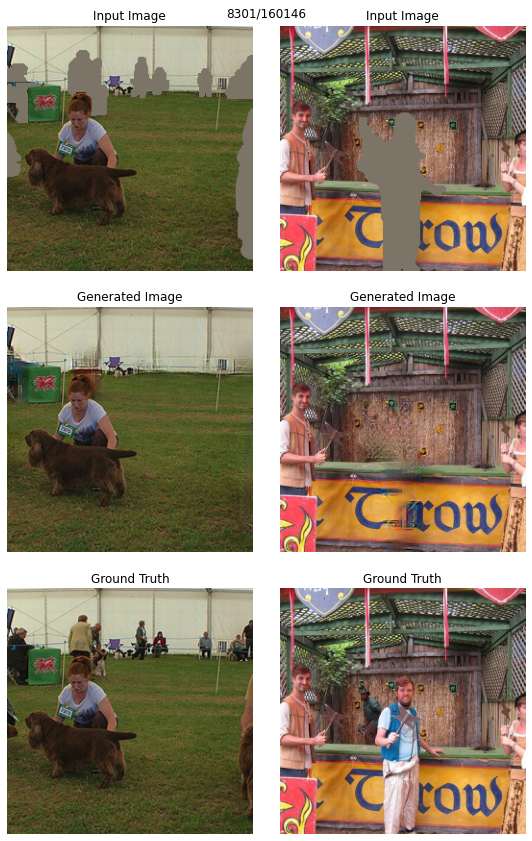

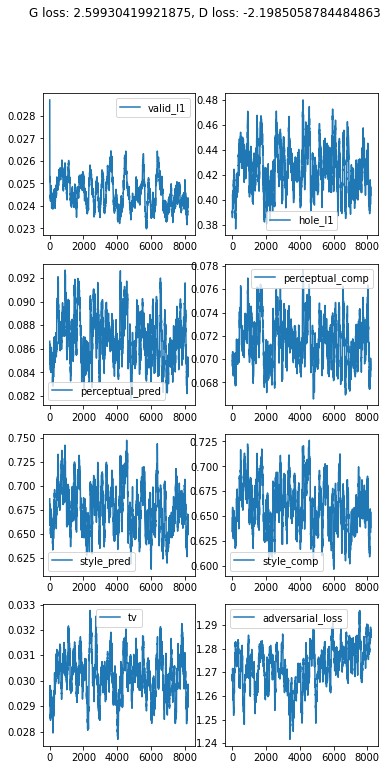

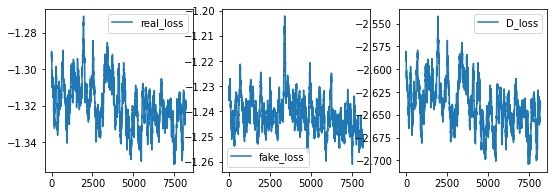

In [ ]:
train(
    model, optimizer, discriminator, discriminator_optimizer, dataloader, validation_dataset, 
    criterion, discriminator_criterion, dataset_mean, dataset_std, 
    epochs=1, device=DEVICE, trained_iters=trained_iters, save_folder=save_folder, save_interval=5000,
    save_name=save_name, losses_smooth_window=100, graph_show_interval=100, train_model=True, critic_steps=5
)